In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `E:\Projects\AC-OPF\Project.toml`


## Library downloads

In [2]:
using JuMP,Ipopt,MosekTools, PyPlot
ipopt = () -> Ipopt.Optimizer()
mosek = () -> Mosek.Optimizer()

#3 (generic function with 1 method)

## Data Structure and auxiliary functions

In [3]:
include("../src/structs.jl")
include("../src/data_read.jl")
include("../src/utils.jl")

graph_dispersion (generic function with 1 method)

## Data Download

Data library: [pglib-opf-master](https://github.com/power-grid-lib/pglib-opf)

In [4]:
full_data = raw"..\data\pglib-opf"

"..\\data\\pglib-opf"

# Model build

## Functions related to electrical grid graph

Consider a non-directed graph with $\mathcal{N} = (\mathcal{B},\mathcal{L})$, where $\mathcal{B}$ is the set of buses and $\mathcal{L}$ the set of transmission lines. The set of Generators $\mathcal{G}$ is a subset of $\mathcal{B}$.

In [5]:
function bus_id(Buses)
    count = 1
    dict_buses = Dict()
    for bus in Buses
        dict_buses[bus.bus_i] = count
        count += 1
    end
    dict_buses
end

bus_id (generic function with 1 method)

The function $\delta$ receive a bus as attribute and returns all lines connected to it.

In [6]:
function δ(i,Branches,Buses)
    tbuses = []
    dict_buses = bus_id(Buses)
    count = 1
    ls = []
    for branch in Branches
        if dict_buses[branch.fbus] == i
            push!(tbuses,dict_buses[branch.tbus])
            push!(ls,count)
        end
        if dict_buses[branch.tbus] == i
            push!(tbuses,dict_buses[branch.fbus])
            push!(ls,count)
        end
        count += 1
    end
    (tbuses,ls)
end

δ (generic function with 1 method)

In [7]:
function From_nodes(i,Branches,Buses)
    tbuses = []
    ls = []
    count = 1
    dict_buses = bus_id(Buses)
    for branch in Branches
        if dict_buses[branch.fbus] == i
            push!(tbuses,dict_buses[branch.tbus])
            push!(ls,count)
        end
        count += 1
    end
    (tbuses,ls)
end

function To_nodes(i,Branches,Buses)
    tbuses = []
    ls = []
    count = 1
    dict_buses = bus_id(Buses)
    for branch in Branches
        if dict_buses[branch.tbus] == i
            push!(tbuses,dict_buses[branch.fbus])
            push!(ls,count)
        end
        count += 1
    end
    (tbuses,ls)
end

To_nodes (generic function with 1 method)

In [8]:
function G(i,Generators,Buses)
    G_i = []
    count = 1
    dict_buses = bus_id(Buses)
    for gen in Generators
        if dict_buses[gen.bus] == i
            push!(G_i,count)
        end
        count += 1
    end
    G_i
end

G (generic function with 1 method)

## Constants

- $Y_l^{Re}$: Series admittance (real)
- $Y_l^{Im}$: Series admittance (imaginary)
- $T_l^{Re}$: Transformer parameters (real)
- $T_l^{Im}$: Transformer parameters (imaginary)
- $b_l$: Line charge
- $s_l^u$: Thermal limits
- $\theta_{min}$,$\theta_{max}$: Branch voltage angle difference range

In [9]:
function add_constants(Branches)
    YR = zeros(length(Branches))
    YI = zeros(length(Branches))
    TR = zeros(length(Branches))
    TI = zeros(length(Branches))
    B = zeros(length(Branches))
    thermal_lim = zeros(length(Branches))
    ang_min = zeros(length(Branches))
    ang_max = zeros(length(Branches))
    for l=1:length(Branches)
        YR[l] = Branches[l].r/(Branches[l].r^2+Branches[l].x^2)
        YI[l] = -Branches[l].x/(Branches[l].r^2+Branches[l].x^2)
        TR[l] = Branches[l].ratio*cos(Branches[l].angle)
        TI[l] = Branches[l].ratio*sin(Branches[l].angle)
        B[l] = Branches[l].b
        thermal_lim[l] = Branches[l].rateA/100.0
        ang_min[l] = Branches[l].angmin*pi/180
        ang_max[l] = Branches[l].angmax*pi/180
    end
    return YR,YI,TR,TI,B,thermal_lim,ang_min,ang_max
end

add_constants (generic function with 1 method)

## Unrelaxed variables

- $p_g^i \hspace{0.2cm} \forall i \in \mathcal{B}$: Power Output (active)
- $q_g^i \hspace{0.2cm} \forall i \in \mathcal{B}$: Power Output (reactive)
- $S^{Re}_{i,j,l} \hspace{0.2cm} \forall (i,j,l) \in \mathcal{L}$: Power flow on line (active)
- $S^{Im}_{i,j,l} \hspace{0.2cm} \forall (i,j,l) \in \mathcal{L}$: Power flow on line (reactive)

In [10]:
function add_global_variables!(model, Buses, Generators, Branches, thermal_lim; start=false)
    if start
        arr1 = ones(length(Buses))
        arr2 = ones(length(Generators))
        arr3 = ones(length(Branches))
        @variable(model, Generators[i].Pmin/100.0 <= p_g[i=1:length(Generators)] <= Generators[i].Pmax/100.0, start = arr2[i])
        @variable(model, Generators[i].Qmin/100.0 <= q_g[i=1:length(Generators)] <= Generators[i].Qmax/100.0, start = arr2[i])
        SR = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SR",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l], start = arr3[l])
        SI = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SI",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l], start = arr3[l])
    else
        @variable(model, Generators[i].Pmin/100.0 <= p_g[i=1:length(Generators)] <= Generators[i].Pmax/100.0)
        @variable(model, Generators[i].Qmin/100.0 <= q_g[i=1:length(Generators)] <= Generators[i].Qmax/100.0)
        SR = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SR",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l])
        SI = @variable(model,[(i,j,l) in [(i,j,l) for i = 1:length(Buses) for (j,l) in zip(δ(i,Branches,Buses)...)]], base_name = "SI",lower_bound = -thermal_lim[l], upper_bound = thermal_lim[l])
    end
    model[:SR] = SR
    model[:SI] = SI
end

add_global_variables! (generic function with 1 method)

## Voltage Variables

- $V_i^{Re} \hspace{0.2cm} \forall i \in \mathcal{B}$: Bus Voltage (active)
- $V_i^{Im} \hspace{0.2cm} \forall i \in \mathcal{B}$: Bus Voltage (reactive)

In [11]:
function add_voltage_variables!(model, Buses; start = false)
    if start
        arr1 = ones(length(Buses))
        @variable(model, - Buses[i].Vmax <= VR[i=1:length(Buses)] <= Buses[i].Vmax , start = arr1[i])
        @variable(model, - Buses[i].Vmax <= VI[i=1:length(Buses)] <= Buses[i].Vmax , start = arr1[i])
    else
        @variable(model, - Buses[i].Vmax <= VR[i=1:length(Buses)] <= Buses[i].Vmax)
        @variable(model, - Buses[i].Vmax <= VI[i=1:length(Buses)] <= Buses[i].Vmax)
    end
end

add_voltage_variables! (generic function with 1 method)

## Constraints

### Reference angle
- Constraint:
    - $\angle V_I(1) = 0$

In [12]:
function add_reference_angle!(model, Buses)
    VI = variable_by_name(model, "VI[1]")
    @constraint(model, VI == 0)
end

add_reference_angle! (generic function with 1 method)

### Power Balance
- Real and Imaginary part of a complex number: $\Re(\cdot),\Im(\cdot)$ 
- Constant Power Demand on bus i (active)  : $P^d_i$
- Constant Power Demand on bus i (reactive): $Q^d_i$
- Bus Shunt Admittance: $Y^s_i$
- Constraints:
    - $\sum_{i \in G(i)} p_g^i - P^d_i + \Re(Y^s_i) |V_i|^2 = \sum_{(l,j) \in \delta(i)} S_{lij}^{Re} \hspace{0.2cm}  \forall i \in \mathcal{B}$ (active)
    - $\sum_{i \in G(i)} q_g^i - Q^d_i + \Im(Y^s_i) |V_i|^2 = \sum_{(l,j) \in \delta(i)} S_{lij}^{Re} \hspace{0.2cm}  \forall i \in \mathcal{B}$ (reactive)

In [13]:
function constraint_power_balance!(model, Buses, Generators, Branches, sqrd_volt, i)
    p_g = model[Symbol("p_g")]
    q_g = model[Symbol("q_g")]
    SR = model[Symbol("SR")]
    SI = model[Symbol("SI")]
    @constraint(model, sum(p_g[i] for i in G(i,Generators,Buses)) - Buses[i].Pd/100.0 + Buses[i].Gs/100.0*sqrd_volt == sum(SR[(i,j,l)] for (j,l) in zip(δ(i,Branches,Buses)...)))
    @constraint(model, sum(q_g[i] for i in G(i,Generators,Buses)) - Buses[i].Qd/100.0 + Buses[i].Bs/100.0*sqrd_volt == sum(SI[(i,j,l)] for (j,l) in zip(δ(i,Branches,Buses)...)))
end

constraint_power_balance! (generic function with 1 method)

### Voltage Bounds
- $v_i^l,v_i^u$: Lower and upper voltages limits
- Constraints:
    - $(v_i^l)^2 \leq |V_i|^2 \leq (v_i^u)^2 \hspace{0.2cm} \forall i \in \mathcal{B}$

In [14]:
function voltage_bounds_sqrd!(model, Buses, sqrd_volt, i)
    @constraint(model, Buses[i].Vmin^2 <= sqrd_volt <= Buses[i].Vmax^2)
end

voltage_bounds_sqrd! (generic function with 1 method)

### Line Balance
- Constraints:
    - $S_{lij}^{Re} = Y_l^{Re} |V_i|^2 - Y_l^{Re}c_{ij} - Y_l^{Im}s_{ij} \hspace{0.2cm} \forall (l,i,j) \in \mathcal{L}$
    - $S_{lij}^{Im} = -(Y_l^{Im}-b_l/2) |V_i|^2 + Y_l^{Im}c_{ij} - Y_l^{Re}s_{ij} \hspace{0.2cm} \forall (l,i,j) \in \mathcal{L}$
    - $c_{ij} = V_i^{Re}V_j^{Re}+V_i^{Im}V_j^{Im}$
	- $s_{ij} = V_i^{Im}V_j^{Re}-V_i^{Re}V_j^{Im}$

In [15]:
function constraint_line_balance!(model, YR, YI, B, sqrd_volt_i, sqrd_volt_j, sum_product_voltages,  diff_product_voltages, i, j, l)
    SR = model[Symbol("SR")]
    SI = model[Symbol("SI")]
    
    @constraint(model, SR[(i,j,l)] == YR*sqrd_volt_i + (-YR)*sum_product_voltages + (-YI)*(diff_product_voltages))
            
    @constraint(model, SI[(i,j,l)] == -(YI+B/2)*sqrd_volt_i - (-YI)*sum_product_voltages + (-YR)*diff_product_voltages)

    @constraint(model, SR[(j,i,l)] == YR*sqrd_volt_j + (-YR)*sum_product_voltages + (-YI)*(-(diff_product_voltages)))

    @constraint(model, SI[(j,i,l)] == -(YI+B/2)*sqrd_volt_j - (-YI)*sum_product_voltages + (-YR)*(-(diff_product_voltages)))
end

constraint_line_balance! (generic function with 1 method)

### Line thermal limit

- Constraints:
    - $(S_{lij}^{Re})^2 + (S_{lij}^{Im})^2 \leq (s_l^u)^2 \hspace{0.2cm} \forall (l,i,j) \in \mathcal{L}$

In [16]:
function line_thermal_bounds_sqrd!(model,thermal_lim, i, j, l)
    SR = model[Symbol("SR")]
    SI = model[Symbol("SI")]
    
    @constraint(model, SI[(i,j,l)]^2+SR[(i,j,l)]^2 <= thermal_lim[l]^2)
    @constraint(model, SI[(j,i,l)]^2+SR[(j,i,l)]^2 <= thermal_lim[l]^2)
end

line_thermal_bounds_sqrd! (generic function with 1 method)

### Phase Angle Differences

- Constraints:
    - $ c_{ij} \tan(\theta_{min}) \leq s_{ij} \leq c_{ij} \tan(\theta_{max})$
    - $c_{ij} = V_i^{Re}V_j^{Re}+V_i^{Im}V_j^{Im}$
	- $s_{ij} = V_i^{Im}V_j^{Re}-V_i^{Re}V_j^{Im}$

In [17]:
function constraint_phase_angle_diff!(model, ang_max, ang_min, sum_product_voltages,  diff_product_voltages, i, j, l) 
    @constraint(model, diff_product_voltages <= tan(ang_max[l])*sum_product_voltages)
    @constraint(model, diff_product_voltages >= tan(ang_min[l])*sum_product_voltages)
end

constraint_phase_angle_diff! (generic function with 1 method)

## Objective Function

### Generator fuel cost minimization
- $\min \sum_{k \in \mathcal{G}} c_{2k} (p_k^g)^2 + c_{1k} p_k^g + c_{0k}$

In [18]:
function add_objective!(model, GeneratorCosts)
    p_g = model[Symbol("p_g")]
    q_g = model[Symbol("q_g")]
    obj = sum([GeneratorCosts[k].c2*p_g[k]^2*100.0^2+GeneratorCosts[k].c1*p_g[k]*100.0+GeneratorCosts[k].c0 for k = 1:length(GeneratorCosts)])
    @objective(model, Min, obj)
end

add_objective! (generic function with 1 method)

# Convex Relaxations

Consider the complex matrix $X \in \mathbb{R}^{\mathcal{|B|}\times \mathcal{|B|}}$
- $X = V(V^T)^*$
- $X_{ij} = V_iV_j^* \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$

$X$ is positive semidefinite matrix with rank $1$.

We can substitute the complex matrix to a real matrix $W \in \mathbb{R}^{2\mathcal{|B|}\times 2 \mathcal{|B|}}$, with the following transformations:

- $W_{ij}   = V_i^{Re}V_j^{Re} \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$
- $W_{i'j'} = V_i^{Im}V_j^{Im} \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$
- $W_{i'j}  = V_i^{Im}V_j^{Re} \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$
- $W_{ij'}  = V_i^{Re}V_j^{Im} \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$

Where $i' = i + |\mathcal{B}|$ and $j' = i + |\mathcal{B}|$.

$W$ is positive semidefinite matrix with rank $1$.

## McCormick Envelopes

The McCormick envelopes are the convex hull of the set $\{(x,y,w) \hspace{0.1cm} | \hspace{0.1cm} w = xy, (x,y) \in [\underline{x}, \bar{x}] \times [\underline{y}, \bar{y}]\}$, which are:
- $MC(w = xy) = \{(x, y, w): \max \{\underline{y} x+\underline{x} y-\underline{x} \underline{y}, \bar{y} x+\bar{x} y-\overline{x y}\} \leq w \leq \min \{\underline{y} x+\bar{x} y-\bar{x} \underline{y}, \bar{y} x+\underline{x} y-\underline{x} \bar{y}\}\}$

### Function to make McCormick envelopes

In [19]:
function MC_Envelopes!(model,w,x,y)
    x_up = upper_bound(x) 
    x_down = lower_bound(x)
    y_up = upper_bound(y) 
    y_down = lower_bound(y)
    @constraint(model, y_down*x+x_down*y-x_down*y_down <= w)
    @constraint(model, w <= y_down*x+x_up*y-x_up*y_down)
    @constraint(model, y_up*x+x_up*y-x_up*y_up <= w)
    @constraint(model, w <= y_up*x+x_down*y-x_down*y_up)
end

MC_Envelopes! (generic function with 1 method)

### Relaxation with McCormick Envelopes

- $MC(W_{ij}   = V_i^{Re}V_j^{Re}) \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$
- $MC(W_{i'j'} = V_i^{Im}V_j^{Im}) \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$
- $MC(W_{i'j}  = V_i^{Im}V_j^{Re}) \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$
- $MC(W_{ij'}  = V_i^{Re}V_j^{Im}) \hspace{0.2cm} \forall (i,j) \in \mathcal{B}^2$

In [20]:
function MC_relaxation!(model,Buses,Branches)
    VR = model[Symbol("VR")]
    VI = model[Symbol("VI")]
    @variable(model, W[i=1:2*length(Buses),j=1:2*length(Buses)])
    s = x -> x+length(Buses)
    sqrd_volt = [W[i,i]+W[s(i),s(i)] for i=1:length(Buses)]
    for i=1:length(Buses)
        MC_Envelopes!(model, W[i,i], VR[i], VR[i])
        MC_Envelopes!(model, W[s(i),s(i)], VI[i], VI[i])
    end
    for i=1:length(Buses)
        for (j,l) in zip(From_nodes(i,Branches,Buses)...)    
            MC_Envelopes!(model,W[i,j]      ,VR[i],VR[j])
            MC_Envelopes!(model,W[s(i),s(j)],VI[i],VI[j])
            MC_Envelopes!(model,W[s(i),j]   ,VI[i],VR[j])
            MC_Envelopes!(model,W[j,i]      ,VR[j],VR[i])
            MC_Envelopes!(model,W[s(j),s(i)],VI[j],VI[i])
            MC_Envelopes!(model,W[j,s(i)]   ,VR[i],VI[j])
        end
    end
end

MC_relaxation! (generic function with 1 method)

## Semidefinite Relaxation

- The rank $1$ restriction of $W$ matrix is non-convex, so we remove this constraint.

In [21]:
function SDP_relaxation!(model,Buses)
    @variable(model, W[i=1:2*length(Buses),j=1:2*length(Buses)],PSD)
end

SDP_relaxation! (generic function with 1 method)

## Second Order Cone Relaxation

The SOCP relaxation consists in relaxing the equalitry $X = V(V^*)^T$ to an inequality

$\hspace{0.5cm} \begin{array}{l}
	X_{i j}=V_{i} V_{j}^{*} \\
	X_{i j} X_{i j}^{*}=V_{i} V_{j}^{*} V_{i}^{*} V_{j} \\
	\left|X_{i j}\right|^{2}=X_{i i} X_{j j} \\
	\left|X_{i j}\right|^{2} \leqslant X_{i i} X_{j j}
	\end{array}$

Writing as a second order cone:

$\hspace{0.5cm} \left|\left(\begin{array}{c}
		2 X_{i j} \\
		X_{i i}-X_{j j}
		\end{array}\right) \right| \leqslant X_{i i}+X_{j j}$
        
In function of $W$:

$\hspace{0.5cm} \left|\left(\begin{array}{c}
2(W_{i j}+W_{i' j'}) \\
W_{i i}+W_{i' i'}-W_{j j}-W_{j' j'}
\end{array}\right) \right| \leqslant W_{i i}+W_{i' i'}+W_{j j}+W_{j' j'}$

In [22]:
function SOCP_relaxation!(model,Buses,Branches)
    @variable(model, W[i=1:2*length(Buses),j=1:2*length(Buses)])
    s = x -> x+length(Buses)
    for i=1:length(Buses)
        for (j,l) in zip(From_nodes(i,Branches,Buses)...)
            @constraint(model, [W[i,i]+W[s(i),s(i)]+W[j,j]+W[s(j),s(j)], 2*(W[i,j]+W[s(i),s(j)]), W[i,i]+W[s(i),s(i)]-W[j,j]-W[s(j),s(j)]] in SecondOrderCone())
        end
    end
end

SOCP_relaxation! (generic function with 1 method)

# Model

In [23]:
function build_problem(file::String, optimizer, relaxation::RELAXATION)
    Buses, Generators, GeneratorCosts, Branches = read_matlab_file(file);
    YR,YI,TR,TI,B,thermal_lim,ang_min,ang_max = add_constants(Branches)
    model = Model(optimizer)
    if relaxation == NL
        add_global_variables!(model, Buses, Generators, Branches, thermal_lim, start = true)
    else
        add_global_variables!(model, Buses, Generators, Branches, thermal_lim)
    end
    add_objective!(model, GeneratorCosts)
    
    if relaxation == NL 
        add_voltage_variables!(model, Buses, start = true)
    elseif relaxation == MC
        add_voltage_variables!(model, Buses)
    end
    if relaxation == NL || relaxation == MC
        add_reference_angle!(model, Buses)
        VR = model[Symbol("VR")]
        VI = model[Symbol("VI")]
    end
    
    if relaxation == NL
        sqrd_volt = VR.^2 .+ VI.^2
    end
    
        
    if relaxation == MC
        MC_relaxation!(model,Buses,Branches)
    end
    if relaxation == SDP
        SDP_relaxation!(model,Buses)
    end
    if relaxation == SOCP
        SOCP_relaxation!(model,Buses,Branches)
    end
    
    if relaxation == MC || relaxation == SDP || relaxation == SOCP
        W = model[Symbol("W")]
        s = x -> x+length(Buses)
        sqrd_volt = [W[i,i]+W[s(i),s(i)] for i=1:length(Buses)]
    end
    
    for i=1:length(Buses)
        constraint_power_balance!(model, Buses, Generators, Branches, sqrd_volt[i], i)
        voltage_bounds_sqrd!(model, Buses, sqrd_volt[i], i)
    end
    
    for i=1:length(Buses)
        for (j,l) in zip(From_nodes(i,Branches,Buses)...)
            if relaxation == NL
                sum_product_voltages  = VR[i]*VR[j]+VI[i]*VI[j]
                diff_product_voltages = VI[i]*VR[j]-VR[i]*VI[j]
            elseif relaxation == MC || relaxation == SDP || relaxation == SOCP
                sum_product_voltages  = W[i,j]+W[s(i),s(j)]
                diff_product_voltages = W[s(j),i]-W[s(i),j]
            end
            constraint_line_balance!(model, YR[l], YI[l], B[l], sqrd_volt[i], sqrd_volt[j], sum_product_voltages,  diff_product_voltages, i, j, l)
            constraint_phase_angle_diff!(model, ang_max, ang_min, sum_product_voltages, diff_product_voltages, i, j, l)
            line_thermal_bounds_sqrd!(model,thermal_lim, i, j, l)
        end
    end
    return model
end

build_problem (generic function with 1 method)

# Tests

## 5 buses

$|\mathcal{B}| = 5 $

$|\mathcal{L}| = 6 $

$|\mathcal{G}| = 5 $

In [24]:
case_test = case_tests[2]

("pglib_opf_case5_pjm", [17552.0, 76377.0, 26109.0])

In [25]:
optimal_value = case_test[2][1]
filepath = joinpath(full_data,case_test[1]*".m")

"..\\data\\pglib-opf\\pglib_opf_case5_pjm.m"

### Non linear - IPOPT

In [26]:
model_nl = build_problem(filepath,ipopt,NL);

In [27]:
optimize!(model_nl)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      299
Number of nonzeros in inequality constraint Jacobian.:      140
Number of nonzeros in Lagrangian Hessian.............:      236

Total number of variables............................:       44
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       44
                     variables with only upper bounds:        0
Total number of equality constraints.................:       35
Total number of inequality co

In [28]:
optimality_gap(model_nl,optimal_value)

0.0006219265170340669

### McCormick Relaxation - MOSEK

In [29]:
model_mc = build_problem(filepath,mosek,MC);

In [30]:
optimize!(model_mc)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 286             
  Cones                  : 13              
  Scalar variables       : 195             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 14
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

In [31]:
optimality_gap_mosek(model_mc,optimal_value,filepath)

37.995725918432086

### Semidefinite Relaxation - MOSEK

In [32]:
model_sdp = build_problem(filepath,mosek,SDP);

In [33]:
optimize!(model_sdp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 101             
  Cones                  : 13              
  Scalar variables       : 85              
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [34]:
optimality_gap_mosek(model_sdp,optimal_value,filepath)

5.220024825996098

### Second Order Cone Relaxation - MOSEK

In [35]:
model_socp = build_problem(filepath,mosek,SOCP);

In [36]:
optimize!(model_socp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 119             
  Cones                  : 19              
  Scalar variables       : 203             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 17
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective s

In [37]:
optimality_gap_mosek(model_socp,optimal_value,filepath)

15.60366270289265

### Results

In [38]:
models = [model_nl,model_mc,model_sdp,model_socp];

In [39]:
function plot_var(models,variable,title,y_label)
    fig = figure(1)
    ax = fig.add_subplot(1,1,1)
    vars = [value.(model[Symbol(variable)]) for model in models]
    var_length = length(vars[1])
    models_type = ["NL","MC","SDP","SOCP"]
    width = 0.15
    G_labels = ["G"*string(i) for i = 1:var_length]
    xs = 1:var_length
    for (i,var) in enumerate(vars)
        ax.bar(xs.+(i-2.5)*width,var,width,label = models_type[i])
    end
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xticks(xs)
    ax.set_xticklabels(G_labels)
    ax.legend()
    return fig
end

plot_var (generic function with 1 method)

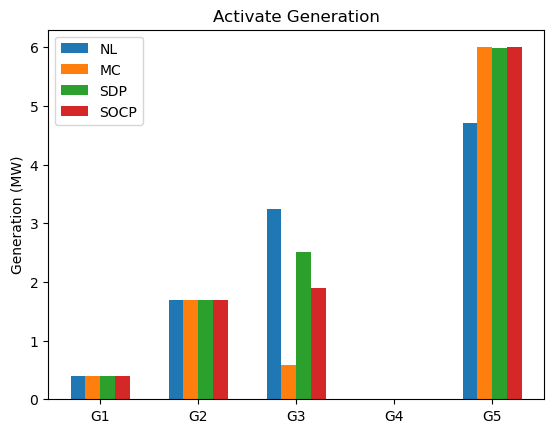

In [40]:
plot_var(models,"p_g","Activate Generation","Generation (MW)");

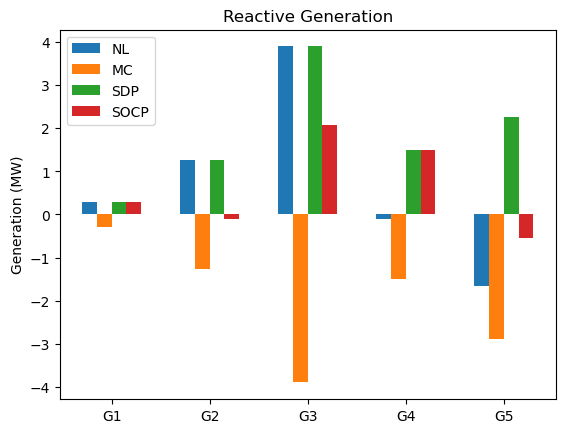

In [41]:
plot_var(models,"q_g","Reactive Generation","Generation (MW)");

## 39 buses

$|\mathcal{B}| = 39 $

$|\mathcal{L}| = 46 $

$|\mathcal{G}| = 10 $

In [42]:
case_test = case_tests[7]

("pglib_opf_case39_epri", [138420.0, 249670.0, 148340.0])

In [43]:
filepath = joinpath(full_data,case_test[1]*".m")
optimal_value = case_test[2][1]

138420.0

### Non linear - IPOPT

In [44]:
model_nl = build_problem(filepath,ipopt,NL);

In [45]:
optimize!(model_nl)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2149
Number of nonzeros in inequality constraint Jacobian.:     1076
Number of nonzeros in Lagrangian Hessian.............:     1764

Total number of variables............................:      282
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      282
                     variables with only upper bounds:        0
Total number of equality constraints.................:      263
Total number of inequality constraints...............:      262
        inequality constraints with only lower bounds:       85
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      177

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3768653e+04 1.20e+01 7.11e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [46]:
optimality_gap(model_nl,optimal_value)

-0.02933882657305836

### McCormick Relaxation - MOSEK

In [47]:
model_mc = build_problem(filepath,mosek,MC);

In [48]:
optimize!(model_mc)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2180            
  Cones                  : 93              
  Scalar variables       : 6737            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 97
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

In [49]:
optimality_gap_mosek(model_mc,optimal_value,filepath)

26.360692490896447

### Semidefinite Relaxation - MOSEK

In [50]:
model_sdp = build_problem(filepath,mosek,SDP);

In [51]:
optimize!(model_sdp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 763             
  Cones                  : 93              
  Scalar variables       : 575             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 9
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [52]:
optimality_gap_mosek(model_sdp,optimal_value,filepath)

0.018958020297554896

### Second Order Cone Relaxation - MOSEK

In [53]:
model_socp = build_problem(filepath,mosek,SOCP);

In [54]:
optimize!(model_socp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 901             
  Cones                  : 139             
  Scalar variables       : 6797            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 144
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 2
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective 

In [55]:
optimality_gap_mosek(model_socp,optimal_value,filepath)

1.618985582065782

### Results

In [56]:
models = [model_nl,model_mc,model_sdp,model_socp];

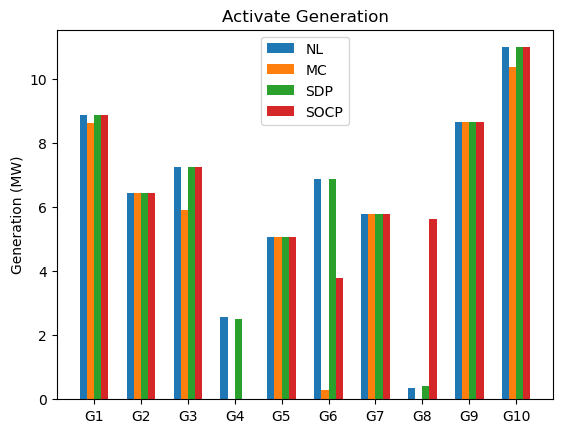

In [57]:
plot_var(models,"p_g","Activate Generation","Generation (MW)");

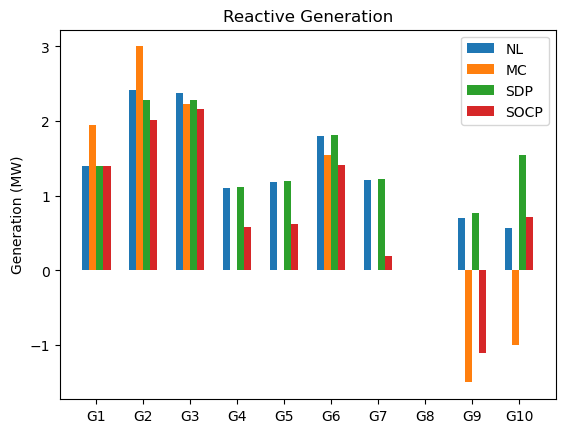

In [58]:
plot_var(models,"q_g","Reactive Generation","Generation (MW)");

## 162 buses

$|\mathcal{B}| = 162 $

$|\mathcal{L}| = 284 $

$|\mathcal{G}| = 12 $

In [59]:
case_test = case_tests[12]

("pglib_opf_case162_ieee_dtc", [108080.0, 120990.0, 108690.0])

In [60]:
filepath = joinpath(full_data,case_test[1]*".m")
optimal_value = case_test[2][1]

108080.0

### Non linear - IPOPT

In [61]:
model_nl = build_problem(filepath,ipopt,NL);

In [62]:
optimize!(model_nl)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13065
Number of nonzeros in inequality constraint Jacobian.:     6328
Number of nonzeros in Lagrangian Hessian.............:    10544

Total number of variables............................:     1484
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1484
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1461
Total number of inequality constraints...............:     1460
        inequality constraints with only lower bounds:      446
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1014

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4429173e+04 2.56e+01 9.14e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [63]:
optimality_gap(model_nl,optimal_value)

0.7040320218123645

### McCormick Relaxation - MOSEK

In [64]:
model_mc = build_problem(filepath,mosek,MC);

In [65]:
optimize!(model_mc)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 12577           
  Cones                  : 569             
  Scalar variables       : 108735          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 609
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 5
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.06    
Problem
  Name                   :                 
  Objective 

In [66]:
optimality_gap_mosek(model_mc,optimal_value,filepath)

81.46095969300735

### Semidefinite Relaxation - MOSEK

In [67]:
model_sdp = build_problem(filepath,mosek,SDP);

In [68]:
optimize!(model_sdp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4464            
  Cones                  : 569             
  Scalar variables       : 3435            
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 11
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

66  3.7e-07  4.7e-06  1.3e-06  9.74e-01   1.065810025e+05   1.065809940e+05   1.7e-09  10.02 
67  3.0e-08  3.7e-07  3.3e-08  9.89e-01   1.066750877e+05   1.066750873e+05   1.4e-10  10.16 
68  3.0e-09  8.3e-08  1.1e-09  9.99e-01   1.066831056e+05   1.066831055e+05   1.4e-11  10.33 
69  4.7e-11  4.6e-07  2.1e-12  1.00e+00   1.066839956e+05   1.066839956e+05   2.2e-13  10.48 
Optimizer terminated. Time: 10.48   



In [69]:
optimality_gap_mosek(model_sdp,optimal_value,filepath)

1.2916398716091166

### Second Order Cone Relaxation - MOSEK

In [70]:
model_socp = build_problem(filepath,mosek,SOCP);

In [71]:
optimize!(model_socp)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5316            
  Cones                  : 853             
  Scalar variables       : 109263          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 912
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 37
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.05    
Problem
  Name                   :                 
  Objective

In [72]:
optimality_gap_mosek(model_socp,optimal_value,filepath)

9.502835532149886

### Results

In [73]:
models = [model_nl,model_mc,model_sdp,model_socp];

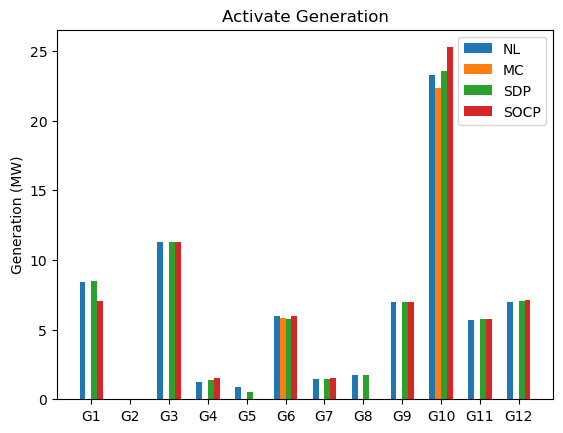

In [74]:
plot_var(models,"p_g","Activate Generation","Generation (MW)");

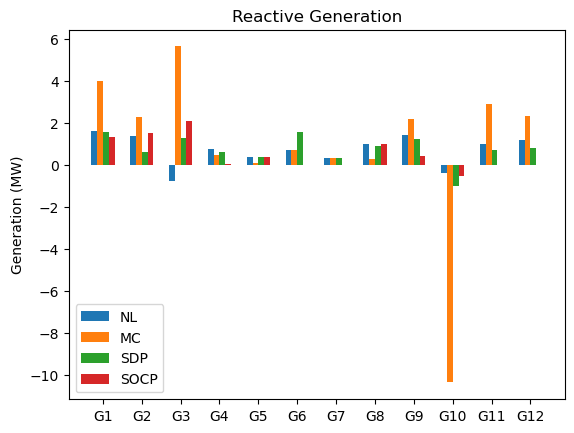

In [75]:
plot_var(models,"q_g","Reactive Generation","Generation (MW)");

# Benchmark Table

## $|\mathcal{B}| \leq 500 $

In [128]:
tests = case_tests[1:17];

### Typical Operating Conditions

In [129]:
cases = benchmark(tests);

In [130]:
print_cases_table(cases)

                                  Percentual Error Table (%)

                     File Name |      NL |      MC |     SDP |    SOCP |
          pglib_opf_case3_lmbd |   0.001 |  39.649 |   0.390 |   2.987 |
           pglib_opf_case5_pjm |   0.001 |  37.996 |   5.220 |  15.604 |
         pglib_opf_case14_ieee |   0.027 | 100.000 |   0.027 |   5.433 |
     pglib_opf_case24_ieee_rts |   0.002 |  25.282 |   0.002 |   3.639 |
           pglib_opf_case30_as |   0.000 |  64.405 |   0.000 |   4.163 |
         pglib_opf_case30_ieee |   0.193 | 100.000 |   0.193 |  30.315 |
         pglib_opf_case39_epri |   0.029 |  26.361 |   0.019 |   1.619 |
         pglib_opf_case57_ieee |   3.517 | 100.000 | 100.000 |   7.275 |
     pglib_opf_case73_ieee_rts |   0.004 |  28.183 |   0.004 |   3.488 |
       pglib_opf_case89_pegase |   0.058 |  54.010 |   0.428 |   2.701 |
        pglib_opf_case118_ieee |   0.011 |  95.029 |   0.066 |   4.227 |
    pglib_opf_case162_ieee_dtc |   0.704 |  81.461 |   1.292 |

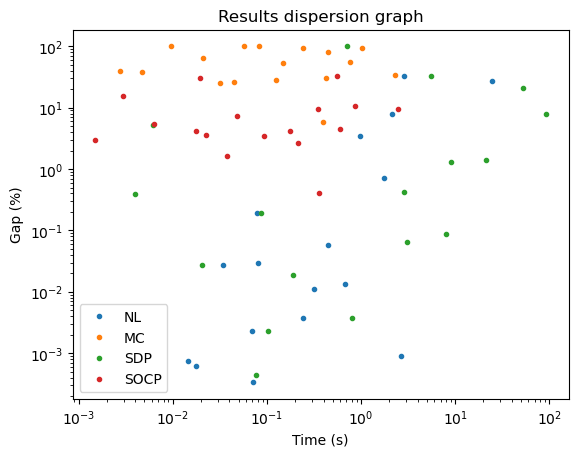

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [131]:
graph_dispersion(cases)

### Congested Operating Conditions

In [132]:
cases = benchmark(tests,API);

In [133]:
print_cases_table(cases)

                                  Percentual Error Table (%)

                     File Name |      NL |      MC |     SDP |    SOCP |
          pglib_opf_case3_lmbd |   0.003 |  39.244 |   7.299 |  11.828 |
           pglib_opf_case5_pjm |   0.001 |  16.260 |   0.255 |   4.501 |
         pglib_opf_case14_ieee |   0.496 | 100.000 |   0.496 |  22.012 |
     pglib_opf_case24_ieee_rts |  22.785 |  51.034 |   3.013 |  26.272 |
           pglib_opf_case30_as |   0.000 |  90.593 |   1.408 |  47.332 |
         pglib_opf_case30_ieee |   0.678 | 100.000 |   0.678 |  14.798 |
         pglib_opf_case39_epri |   3.158 |  16.090 |   2.880 |   3.321 |
         pglib_opf_case57_ieee |   2.204 | 100.000 | 100.000 |   3.558 |
     pglib_opf_case73_ieee_rts |  47.953 |  52.724 |   2.292 |  19.558 |
       pglib_opf_case89_pegase |  17.275 |  92.980 |  21.510 |  25.089 |
        pglib_opf_case118_ieee |   0.303 |  86.644 |  11.811 |  34.654 |
    pglib_opf_case162_ieee_dtc |   0.266 |  80.169 |   0.909 |

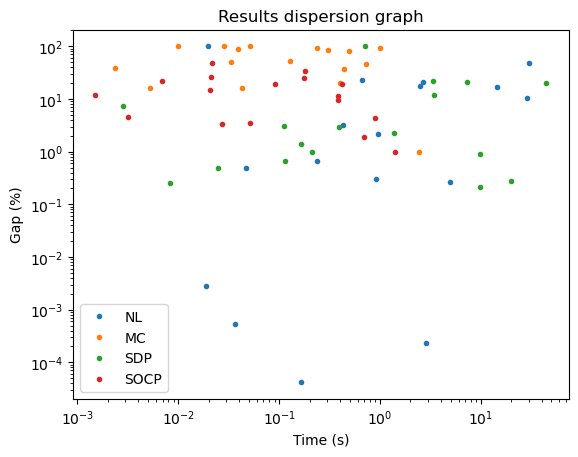

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [134]:
graph_dispersion(cases)

### Small Angle Difference Conditions

In [135]:
cases = benchmark(tests,SAD);

In [136]:
print_cases_table(cases)

                                  Percentual Error Table (%)

                     File Name |      NL |      MC |     SDP |    SOCP |
          pglib_opf_case3_lmbd |   0.000 |  41.134 |   1.858 |   5.324 |
           pglib_opf_case5_pjm |   0.001 |  16.976 |   0.001 |   3.789 |
         pglib_opf_case14_ieee |   0.139 | 100.000 |   0.022 |  25.792 |
     pglib_opf_case24_ieee_rts |   0.866 |  37.255 |   4.631 |  11.877 |
           pglib_opf_case30_as |   0.000 |  68.143 |   0.236 |  10.938 |
         pglib_opf_case30_ieee |   0.193 | 100.000 |   0.193 |  18.842 |
         pglib_opf_case39_epri |   0.915 |  23.623 |   0.993 |   2.756 |
         pglib_opf_case57_ieee |   0.595 | 100.000 | 100.000 |   0.624 |
     pglib_opf_case73_ieee_rts |   0.207 |  38.758 |   2.784 |   8.920 |
       pglib_opf_case89_pegase |   0.058 |  54.010 |   0.428 |   2.692 |
        pglib_opf_case118_ieee |   1.540 |  95.402 |   4.223 |  11.453 |
    pglib_opf_case162_ieee_dtc |   0.744 |  81.548 |   1.605 |

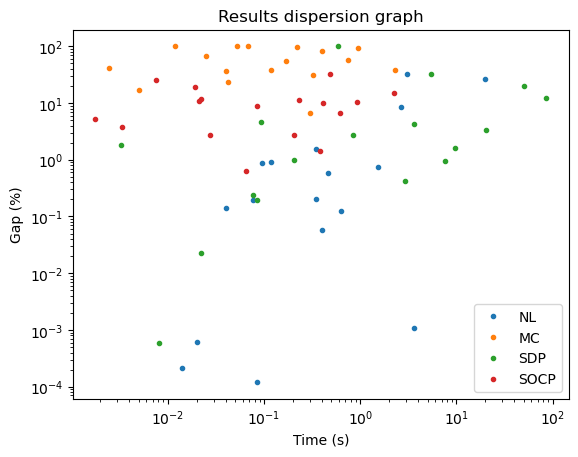

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [137]:
graph_dispersion(cases)

## $588 \leq |\mathcal{B}| \leq 2000 $

In [138]:
remove = [19,24]
range = filter(x -> !(x in remove),18:25);

In [139]:
tests = case_tests[range]

6-element Vector{Tuple{String, Vector{Float64}}}:
 ("pglib_opf_case588_sdet", [313140.0, 394760.0, 329360.0])
 ("pglib_opf_case1354_pegase", [1.2588e6, 1.4983e6, 1.2588e6])
 ("pglib_opf_case1888_rte", [1.4025e6, 1.9539e6, 1.4139e6])
 ("pglib_opf_case1951_rte", [2.0856e6, 2.4108e6, 2.0924e6])
 ("pglib_opf_case2000_goc", [973430.0, 1.4686e6, 992880.0])
 ("pglib_opf_case2383wp_k", [1.8682e6, 279130.0, 1.9112e6])

### Typical Operating Conditions

In [90]:
cases_no_sdp = benchmark(tests,TYP,false);

In [91]:
print_cases_no_sdp_table(cases_no_sdp)

                             Percentual Error Table (%)

                     File Name |       NL |       MC |     SOCP |
        pglib_opf_case588_sdet |   24.376 |    1.000 |    1.000 |
     pglib_opf_case1354_pegase |    0.127 |   61.633 |    4.535 |
        pglib_opf_case1888_rte |   20.657 |   51.178 |    4.766 |
        pglib_opf_case1951_rte |   25.674 |   58.784 |    2.808 |
        pglib_opf_case2000_goc |   23.508 |   26.022 |   16.514 |
        pglib_opf_case2312_goc |  186.051 |    1.000 |    1.000 |

                           Time Elapsed Table

                     File Name |       NL |       MC |     SOCP |
        pglib_opf_case588_sdet |    7.393 |    2.491 |    1.800 |
     pglib_opf_case1354_pegase |   11.288 |   18.230 |   24.635 |
        pglib_opf_case1888_rte |  252.175 |   48.823 |   54.161 |
        pglib_opf_case1951_rte |  123.029 |   49.551 |   57.510 |
        pglib_opf_case2000_goc |  252.086 |   53.355 |   59.422 |
        pglib_opf_case2312_goc |   64

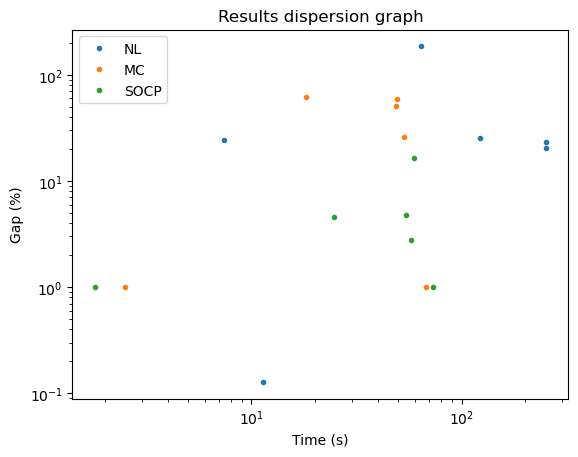

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [92]:
graph_dispersion(cases_no_sdp,sdp=false)

### Congested Operating Conditions

In [93]:
cases_no_sdp = benchmark(tests,API,false);

In [94]:
print_cases_no_sdp_table(cases_no_sdp)

                             Percentual Error Table (%)

                     File Name |       NL |       MC |     SOCP |
        pglib_opf_case588_sdet |  100.000 |    1.000 |    1.000 |
     pglib_opf_case1354_pegase |    0.132 |   94.393 |    3.014 |
        pglib_opf_case1888_rte |  100.000 |    1.000 |    1.000 |
        pglib_opf_case1951_rte |   39.772 |   82.172 |    4.030 |
        pglib_opf_case2000_goc |  100.000 |    1.000 |    1.000 |
        pglib_opf_case2312_goc |  100.000 |    1.000 |    1.000 |

                           Time Elapsed Table

                     File Name |       NL |       MC |     SOCP |
        pglib_opf_case588_sdet |    0.016 |    2.546 |    1.840 |
     pglib_opf_case1354_pegase |    7.541 |   18.377 |   24.255 |
        pglib_opf_case1888_rte |    0.089 |   39.824 |   43.547 |
        pglib_opf_case1951_rte |  218.036 |   48.432 |   55.481 |
        pglib_opf_case2000_goc |    0.156 |   45.583 |   52.503 |
        pglib_opf_case2312_goc |    0

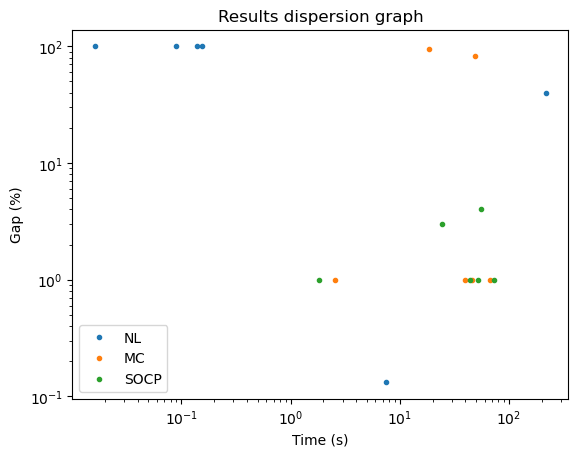

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [95]:
graph_dispersion(cases_no_sdp,sdp=false)

### Small Angle Difference Conditions

In [96]:
cases_no_sdp = benchmark(tests,SAD,false);

In [97]:
print_cases_no_sdp_table(cases_no_sdp)

                             Percentual Error Table (%)

                     File Name |       NL |       MC |     SOCP |
        pglib_opf_case588_sdet |   19.655 |    1.000 |    1.000 |
     pglib_opf_case1354_pegase |    0.103 |   61.633 |    4.535 |
        pglib_opf_case1888_rte |   15.583 |   51.572 |    5.532 |
        pglib_opf_case1951_rte |   25.188 |   58.918 |    3.121 |
        pglib_opf_case2000_goc |   17.376 |    6.528 |  100.179 |
        pglib_opf_case2312_goc |  173.008 |    1.000 |    1.000 |

                           Time Elapsed Table

                     File Name |       NL |       MC |     SOCP |
        pglib_opf_case588_sdet |   10.192 |    2.516 |    1.805 |
     pglib_opf_case1354_pegase |    8.059 |   17.631 |   23.808 |
        pglib_opf_case1888_rte | 3929.113 |   48.732 |   53.934 |
        pglib_opf_case1951_rte |  123.986 |   50.643 |   57.944 |
        pglib_opf_case2000_goc |  176.377 |   54.870 |   62.013 |
        pglib_opf_case2312_goc |   72

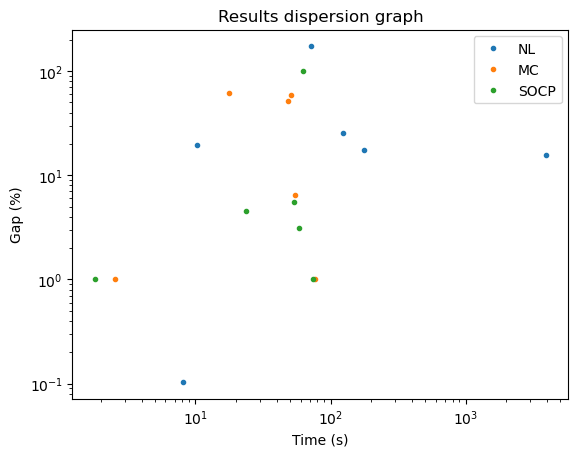

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [98]:
graph_dispersion(cases_no_sdp,sdp=false)